# ML5 Валидация данных

В этом модуле мы будем решать задачу классификации: классифицировать воду на пригодную  и не пригодную для питья на основе её химического состава.

Переходим к работе с данными. Импортируем модули, которые нам понадобятся:

In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

/var/folders/7d/737wrt6574jfhqcjjxv10rnh0000gn/T/ipykernel_41616/3755730.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #стиль отрисовки seaborn


Прочитаем данные о собранных образцах воды и выведем первые пять строк таблицы:

In [4]:
water_data = pd.read_csv('data/water_potability.zip')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода не пригодна.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [5]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [6]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

Убедимся в отсутствии пропусков:

In [7]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [8]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

## Реализация метода HOLD-OUT в sklearn

Метод `hold-out` (отложенная выборка) нам уже знаком. Это самый простой и очень популярный метод.

Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).

Обычно разбиение производится в соотношении 70/30 или 80/20 при двухкомпонентном подходе, и в соотношении 70/15/15 или 80/10/10 — при трёхкомпонентном.

Все методы разбиения выборки и валидации, которые мы будем изучать, находятся в модуле ```model_selection```, мы импортировали его заранее.

Метод hold-out реализован в уже знакомой вам функции ```train_test_split()```. Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

Основные параметры ```train_test_split()```:

* ```*arrays``` — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
* ```test_size``` — размер тестовой (валидационной) выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-train_size.
* ```train_size``` — размер тренировочной выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-test_size.
* ```random_state``` — число, на основе которого производится генерация случайных чисел.
* ```shuffle``` — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию True).
* ```stratify``` — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию ```train_test_split()``` и передать в неё матрицу наблюдений ```X``` и вектор-столбец с правильными ответами ```y```.

Для примера разделим выборку в соотношении 80/20 (```test_size=0.2```), в качестве значения параметра ```random_state``` по традиции возьмём число `42`.

Функция вернёт четыре массива:

* таблицу `X` с обучающими примерами,
* таблицу `X` с примерами для валидации,
* столбец `y` с ответами на обучающие примеры,
* столбец `y` с ответами на валидационные примеры.

In [9]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Проверим размеры полученных выборок:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


Итак, 2 620 образцов воды являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а 656 являются валидационными — на них мы будем производить контроль качества.

Далее нам останется только обучить модель на тренировочной выборке (`X_train`, `y_train`) и рассчитать метрики на валидационной выборке (`X_valid`, `y_valid`).

В качестве модели будем использовать дерево решений с максимальной глубиной `7`, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — `5`.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — `accuracy`.

In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), тут нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию `train_test_split()` дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [12]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

# Выводим размерности:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом  случае мы будем обучаться на 2 620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

## Реализация метода K-FOLD в sklearn

Метод `k-fold` более известен как кросс-валидация (cross validation), или перекрёстный контроль.

Пожалуй, это самый популярный метод валидации для оценки качества моделирования, и он используется практически во всех проектах. Эта идея также применяется во многих моделях и методах машинного обучения, например в стекинге.

Напомним алгоритм кросс-валидации:

* Разбить исходную выборку на  частей — фолдов (fold).
* Повторять  раз:
* * Обучить модель на  частях. Назовём их тренировочными фолдами (training fold). 
* * Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её валидационным фолдом (validation fold).
* Усреднить значения метрики на валидационных фолдах.

В библиотеке `sklearn` метод `k-fold` реализован в классе `KFold`.

Основные параметры инициализатора `KFold`:

* `n_split` —  число фолдов (число  из метода `k-fold`). По умолчанию — 5.
* `shuffle` — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — `False`.
* `random_state` — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

У объекта класса `KFold` есть метод `split()`. В данный метод необходимо передать матрицу наблюдений `X` и вектор-столбец ответов `y` — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу `k-fold`.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект `KFold` для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл `for` для получения элементов из генератора, созданного с помощью метода `split()`. На каждой итерации в переменных `train_index` и `valid_index` будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

* выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
* обучать дерево решений;
* делать предсказания для текущих тренировочной и валидационной выборок;
* рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

Код будет выглядеть следующим образом:

In [14]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))
    
# Выведем содержимое массивов train_metrics и val_metrics:
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [15]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Итак, среднее значение метрики accuracy на кросс-валидации равно 0.81 для тренировочных фолдов и 0.74 — для валидационных фолдов. Помним о том, что основной показатель для нас — метрика на валидационных фолдах (если не предусмотрена тестовая выборка). 

Примечание. Если количество фолдов больше 30, вы можете построить доверительный интервал для среднего значения метрики. О доверительных интервалах мы говорили в модуле по A/B-тестированию.

Согласитесь, сложновато — не совсем в стиле sklearn. Тут и циклы, и генераторы... Неужели каждый раз придётся писать подобный код для проведения кросс-валидации?

Конечно же, нет. На самом деле весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — `cross_validate()` из модуля `model_selection`. Она организует процедуру кросс-валидации и расчёт метрик.

Основные параметры функции `cross_validate()`:

* `estimator` — модель, качество которой будет проверяться на кросс-валидации.
* `X` — матрица наблюдений.
* `y` — вектор-столбец правильных ответов.
* `cv` — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
* `scoring` — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
* `return_train_score` — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

* `fit_time` — время обучения модели на каждой итерации кросс-валидации;
* `score_time` — время вычисления метрик на каждой итерации кросс-валидации;
* `test_score` — значения метрик на валидационных фолдах;
* `train_score` — значения метрик на тренировочных фолдах.

Итоговый код с использованием функции cross_validate() будет выглядеть следующим образом:

In [16]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.01342916, 0.01188302, 0.01226187, 0.01156497, 0.01161599]),
 'score_time': array([0.00090408, 0.00085878, 0.00099516, 0.00115204, 0.0009079 ]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам train_score и test_score, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [17]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Мы получили тот же результат, что и ранее. Согласитесь, функция cross_validate() значительно облегчает работу с кросс-валидацией.

## Реализация метода LEAVE-ONE-OUT в sklearn

Метод leave-one-out (отложенный пример), или поэлементная кросс-валидация — это частный случай кросс-валидации (k-fold), когда размер `k` равняется размеру всей выборки `k = n`, где `n` — количество примеров (строк в таблице).

Алгоритм метода:

* Повторять `n` раз:
* * Выбрать один случайный пример для валидации.
* * Обучить модель на всех оставшихся  примерах.
* * Произвести оценку качества (вычислить метрику) на отложенном примере.
* Усреднить значение метрик на всех примерах.

В библиотеке `sklearn` метод `leave-one-out` реализован в классе `LeaveOneOut`. Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с `KFold`, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса `LeaveOneOut` также можно передать в функцию `cross_validate()` для получения метрик на каждом из примеров. В случае с метрикой `accuracy` список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации `leave-one-out` будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

**Примечание**. Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

In [19]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


### Задание 3.3

Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам:



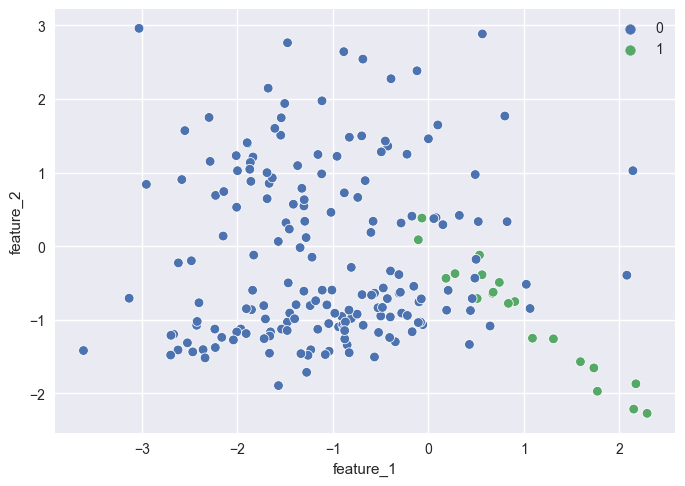

In [33]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

Из приведённых ниже диаграмм выберите ту, которая соответствует полученному разбиению.

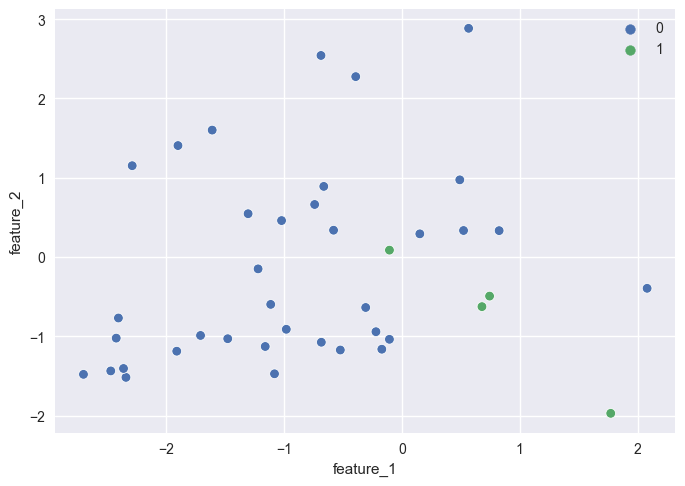

In [27]:
X_t, X_v, y_t, y_v = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sns.scatterplot(x=X_v['feature_1'], y=X_v['feature_2'], hue=y_v);

## ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Мы поговорили о том, как производить разбиение в условиях дисбаланса классов. Следующий пункт в нашем списке проблем — это использование метрик, которые плохо работают с дисбалансом.

Основной представитель таких метрик — это знакомая нам accuracy, доля угаданных моделью ответов. 

Загвоздка заключается в том, что данная метрика абсолютно не отражает предсказательную способность модели в отношении каждого из классов. В условиях дисбаланса классов данная метрика может дать ложные представления о качестве модели.

Поэтому используются метрики, которые концентрируются на каждом из классов отдельно, — это знакомые нам из модуля по классификации `precision`, `recall` и `F1-score`.

Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции `classification_report()`.

In [28]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.50      0.50      0.50         4

    accuracy                           0.90        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.90      0.90      0.90        40



Из отчёта о метриках классификации видно, что для валидационной выборки метрика `accuracy` составляет 0.77, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики `recall` и `f1-score` для каждого из классов в отдельности, мы увидим, что метрики для класса 0 значительно выше, чем метрики для класса 1.

* `Precision` для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.
* `Recall` для класса 1 составляет 0.55, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь 55 %, а остальные 45 % посчитала непригодными.
* `F1-мера` — среднее гармоническое между precision и recall — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.

Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику accuracy. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

### Задание 3.5

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Обучите модель логистической регрессии на тренировочной выборке (все параметры оставьте по умолчанию).

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [41]:
task_model = linear_model.LogisticRegression().fit(X, y)
task_model_pred = task_model.predict(X)
print(metrics.classification_report(y, task_model_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       180
           1       0.73      0.40      0.52        20

    accuracy                           0.93       200
   macro avg       0.83      0.69      0.74       200
weighted avg       0.92      0.93      0.92       200



### Задание 3.6 (на самопроверку)

Воспользуйтесь функцией `plot_probabilities_2d()`, которую мы написали в модуле по классификации, для того, чтобы построить разделяющую поверхность логистической регрессии.

Передайте в её аргументы матрицу наблюдений `X`, вектор ответов `y` и обученную в задании 3.5 логистическую регрессию.

In [35]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


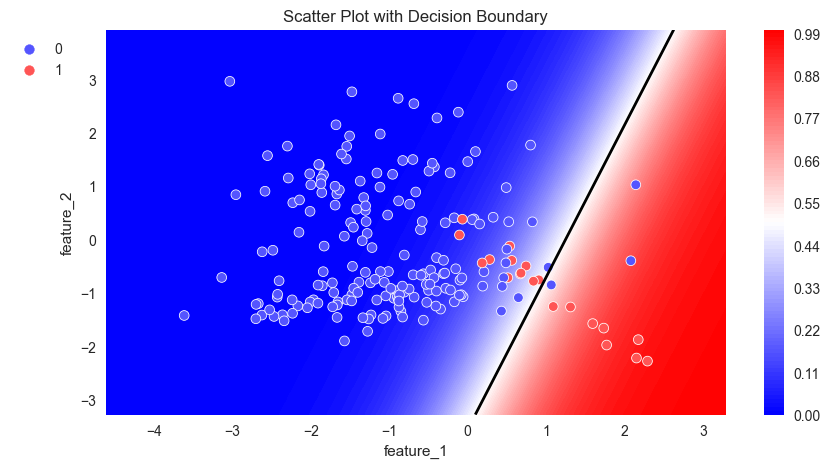

In [36]:
plot_probabilities_2d(X, y, task_model)

### Задание 3.7

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Обучите модель логистической регрессии на тренировочной выборке, установив сбалансированные веса для классов.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [40]:
task_model_balanced = linear_model.LogisticRegression(class_weight='balanced').fit(X, y)
task_model_balanced_pred = task_model.predict(X)
print(metrics.classification_report(y, task_model_balanced_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       180
           1       0.47      0.90      0.62        20

    accuracy                           0.89       200
   macro avg       0.73      0.89      0.78       200
weighted avg       0.94      0.89      0.90       200



### Задание 3.8 (на самопроверку)

Воспользуйтесь функцией `plot_probabilities_2d()`, которую мы написали в модуле по классификации, для того, чтобы построить разделяющую поверхность логистической регрессии со сбалансированными весами классов.

Передайте в её аргументы матрицу наблюдений `X`, вектор ответов `y` и обученную в задании 3.7 логистическую регрессию.

Сравните разделяющую поверхность, построенную в задании 3.5, с полученной вами поверхностью в данном задании.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


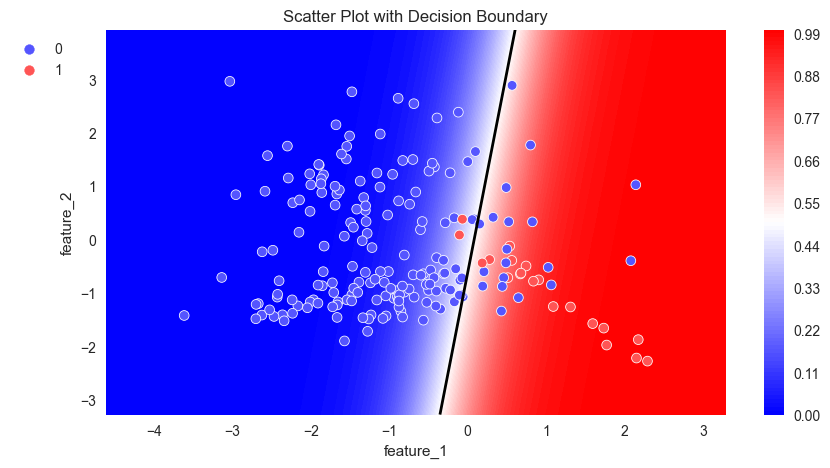

In [43]:
plot_probabilities_2d(X, y, task_model_balanced)